In [42]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import statistics
import kmax as kx
import utility as util
from hierarchy import *
from scipy.optimize import fsolve
from IPython.core.debugger import set_trace
import scipy.stats as stats
import pylab
import statsmodels.api as sm
import math

In [ ]:
num_samples = 10000
seg_lengths = []
LAM = 0.7

# Simulations 3

## Goals:
- Find path segment length for a typical vertex

In [ ]:
# Calculate the length of the path passing 
# through `node` in `path_cover`
def path_seg_length(tree, path_cover, node):
    if len(path_cover) == 0:
        return 0
    
    path_subgraph = tree.edge_subgraph(path_cover)
    if node not in path_subgraph:
        return 0

    # node_connected_component returns a list of nodes, so we subtract 1 to get the number of edges
    return len(nx.node_connected_component(path_subgraph, node)) - 1

def all_path_seg_lengths(tree):
    hist_data = {}
    component_root = 0
    path_cover,_,_,_ = util.path_cover(tree, root=component_root)
    path_subgraph = tree.edge_subgraph(path_cover)
    for path in nx.connected_components(path_subgraph):
        seg_len = len(path) - 1
        if seg_len not in hist_data:
            hist_data[seg_len] = 1
        else:
            hist_data[seg_len] += 1
    
    #seg_lengths = {node : path_seg_length(tree, path_covers[node], node) for node in tree.nodes()}

    return hist_data

def root_seg_length(tree):
    path_cover,_,_,_ = util.path_cover(tree, root=0)
    return path_seg_length(tree, path_cover, 0)

def root_seg_length_z(tree):
    path_cover,_,_,z_root = util.path_cover(tree, root=0)
    return path_seg_length(tree, path_cover, 0), z_root

def solve_p(lam):
    func = lambda p: [p[0] * np.exp(lam*p[0]) - (1 + lam * p[0])]
    return float(fsolve(func, 0)[0])

def compute_L(k):
    p = solve_p(LAM)
    r = LAM * np.exp(-LAM * p)
    return (1-r) * r**(k-2) * (p * r**2 + (1-p) * (1-r) * max(0,(k-1)))

def compute_L_one(k):
    p = solve_p(LAM)
    r = LAM * np.exp(-LAM * p)
    return p * (1-k) * math.pow(r, k)

def compute_L_zero(k):
    p = solve_p(LAM)
    r = LAM * np.exp(-LAM * p)
    return (1-p) * math.pow(1-r, 2) * math.pow(r, k - 2) * max(0, (k-1))

In [ ]:
def draw_tree(tree, layout, draw_path=True):
    rooted_tree = nx.bfs_tree(tree, 0)
    
    #nx.draw_networkx_nodes(tree, pos=layout, node_size=29)
    nx.draw_networkx_labels(tree, pos=layout, font_size=10, font_color="tab:blue")
    
    if draw_path:
        path_cover,_,X,_=util.path_cover(tree)
        nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=path_cover, edge_color="tab:red", arrows=True)
        
        other_edges = [(u,v) for u,v in rooted_tree.edges() if (u,v) not in path_cover and (v,u) not in path_cover]
        nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=other_edges)
    else:
        nx.draw_networkx_edges(rooted_tree, pos=layout)

def generate_histogram(dataset, func = compute_L, bins = np.arange(0,100,1)):
    theoretical_seg_lengths = [func(b) * num_samples for b in bins]
    plt.figure(figsize=(6,6))
    plt.bar(bins, theoretical_seg_lengths, color='red')
    plt.hist(dataset, bins=bins, edgecolor = 'black', linewidth=1.2, color = 'lightblue', alpha=0.5)
    plt.title(f"Path segment length histogram (GWBP, $\lambda={LAM}$, {num_samples} samples)", fontfamily=['Serif'])
    plt.xticks(bins)
    plt.xlabel("Path length in optimal path cover", fontfamily=['Serif'], fontsize=12)
    plt.ylabel("Occurences", fontfamily=['Serif'], fontsize=12)
    plt.show()

### Single Sample

In [46]:
n = 30
lam = 0.7
#sample_tree = nx.fast_gnp_random_graph(n, lam/n)
sample_tree = nx.random_labeled_tree(n)
for u,v in sample_tree.edges():
    sample_tree[u][v]['weight'] = 1

seg_length_counts = all_path_seg_lengths(sample_tree)

In [31]:
seg_length_counts

{12: 1, 3: 4}

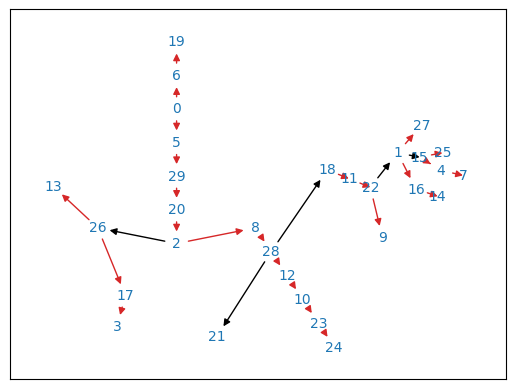

In [32]:
draw_tree(sample_tree, hierarchyc_pos(sample_tree, root=0))

### Average Segment Length

In [49]:
for _ in range(num_samples):
    # Poisson Branching
    sample_tree = nx.Graph(GWBP(LAM, MAXLEVEL=100))
    for u,v in sample_tree.edges():
        sample_tree[u][v]['weight'] = 1

    for (l,c) in all_path_seg_lengths(sample_tree).items():
        for _ in range(c):
            seg_lengths.append(l)

### Root segment length

In [50]:
root_seg_lengths = []
for _ in range(num_samples):
    sample_tree = nx.Graph(GWBP(LAM, MAXLEVEL=100))
    for u,v in sample_tree.edges():
        sample_tree[u][v]['weight'] = 1

    root_seg_lengths.append(root_seg_length(sample_tree))

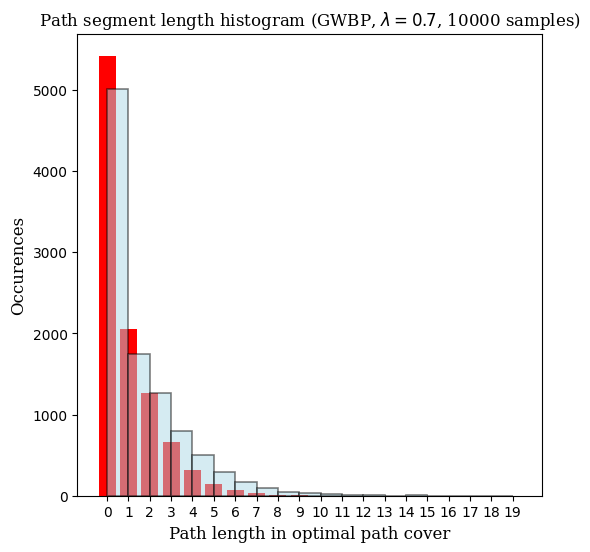

In [51]:
generate_histogram(root_seg_lengths, bins=np.arange(0,20,1))

### Root segmenth length (split by z)

In [52]:
root_seg_lengths_z0 = []
root_seg_lengths_z1 = []
for _ in range(num_samples):
    sample_tree = nx.Graph(GWBP(LAM, MAXLEVEL=100))
    for u,v in sample_tree.edges():
        sample_tree[u][v]['weight'] = 1

    seg_len, z_root = root_seg_length_z(sample_tree)
    if z_root == 0:
        root_seg_lengths_z0.append(seg_len)
    else:
        root_seg_lengths_z1.append(seg_len)

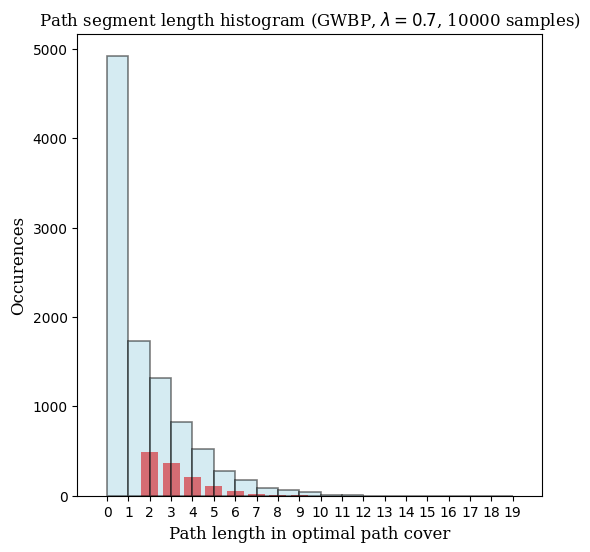

In [56]:
generate_histogram(root_seg_lengths_z0, func = compute_L_zero, bins=np.arange(0,20,1))